# Featurization - `Name` 

In [860]:
import pandas as pd
import numpy as np
import re

In [861]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

In [862]:
df = pd.read_csv("../../data/raw/train.csv").drop('PassengerId', axis=1)
dfX = df.drop('Survived', axis=1)
dfy = df.Survived

In [863]:
# because can't use lambda
def has_pattern(x, pattern, grp):
    res = re.search(pattern, x)
    if grp is None:
        return res
    else:
        return res.group(grp)

In [864]:
def is_df(x):
    return type(x) is pd.DataFrame

In [865]:
def get_title(x, pattern=r'([A-Z][a-z]+)\.'):
    if is_df(x):
        raise NotImplementedError('Please provide a Series')
    else:    
        x = x.apply(has_pattern, pattern=pattern, grp=1)
        
    x.replace(['Mlle', 'Ms'], 'Miss', inplace=True)
    x.replace(['Mme'], 'Mrs', inplace=True)
    return x

In [866]:
titles = get_title(df.Name)
titles

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Name, Length: 891, dtype: object

In [867]:
counts = titles.value_counts()
counts < 10

Mr          False
Miss        False
Mrs         False
Master      False
Dr           True
Rev          True
Major        True
Col          True
Lady         True
Capt         True
Countess     True
Don          True
Sir          True
Jonkheer     True
Name: Name, dtype: bool

In [868]:
titles.apply(lambda x: 'Special' if counts[x] < 10 else x)

0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
        ...   
886    Special
887       Miss
888       Miss
889         Mr
890         Mr
Name: Name, Length: 891, dtype: object

In [869]:
def group_cat(x, setval, thresh):
    counts = x.value_counts()
    def replace(v):
        return (setval if counts[v] <= thresh else v)
    
    return x.apply(replace)

In [870]:
group_cat(titles, 'Special', 10)

0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
        ...   
886    Special
887       Miss
888       Miss
889         Mr
890         Mr
Name: Name, Length: 891, dtype: object

In [871]:
def is_df(x):
    return type(x) is pd.DataFrame

In [872]:
x = df.loc[:, ['Name', 'Name']]

In [873]:
def get_title(x, pattern=r'([A-Z][a-z]+)\.', grp_cats=True, return_df=True):
    
    '''
    Extract the title from the name and into [Mr, Mrs, Miss, Master, {other}]
    
    TODO: Implement for return_df='auto' series -> series, dataframe -> dataframe
    '''
    
    if is_df(x):
        return x.apply(get_title, return_df=False, axis=0)
        
        
    x = x.apply(has_pattern, pattern=pattern, grp=1)
        
    x.replace(['Mlle', 'Ms'], 'Miss', inplace=True)
    x.replace(['Mme'], 'Mrs', inplace=True)
    if grp_cats:
        x.loc[~x.isin(['Mr', 'Mrs', 'Miss', 'Master'])] = 'other'
    
        
    if return_df:
        return pd.DataFrame(x)
    else:
        return x


In [878]:
get_title(df.loc[:, 'Name'], grp_cats=False, return_df=True).Name.value_counts()

Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Major         2
Col           2
Lady          1
Capt          1
Countess      1
Don           1
Sir           1
Jonkheer      1
Name: Name, dtype: int64

In [934]:
class NameTitleExtractor(BaseEstimator, TransformerMixin):
    
    '''
    Extracts the titles from the name
    
    Parameters
    ----------
    
    # TODO: implement passing any excluding categories
    
    exclude_cat_type: str, default: 'type1', options: ['type1', 'type2'] 
        which type of categories to exclude from grouping to 'other'
    '''
    
    exclude_cat_opts = {
        'type1': ['Mr', 'Mrs', 'Miss', 'Master'],
        'type2': ['Mr', 'Mrs', 'Miss', 'Master', 'Dr', 'Rev']
    }
    
    def __init__(self, exclude_cat_type='type1', sparse=False, pattern=r'([A-Z][a-z]+)\.'):
        self.exclude_cat_type = exclude_cat_type
        self.exclude_cat = self.exclude_cat_opts[exclude_cat_type]
        self.cat = self.exclude_cat + ['other']
        self.pattern = pattern
        self.sparse = sparse
        self.ohe = OneHotEncoder([self.cat], drop=['other'], sparse=sparse)
        
    def fit(self, X, y=None):
                    
        try:    
            name = X.name 
        except AttributeError:
            name = 'Name'
            
        dummy_df = pd.DataFrame({name: ['Mr']})
        self.ohe.fit(dummy_df)
        
        return self
    
    def transform(self, X):
        X = X.apply(has_pattern, pattern=self.pattern, grp=1)

        X.replace(['Mlle', 'Ms'], 'Miss', inplace=True)
        X.replace(['Mme'], 'Mrs', inplace=True)
       
        X.loc[~X.isin(self.exclude_cat)] = 'other'
            
        return self.ohe.transform(pd.DataFrame(X))
    
    
    def get_feature_names(self, input_features):
        return self.ohe.get_feature_names(input_features)


            

In [935]:
NameTitleExtractor('type1').fit(df).transform(df.Name).shape

(891, 4)

In [936]:
NameTitleExtractor('type2').fit(1).transform(df.Name).shape

(891, 6)

In [937]:
make_column_transformer((NameTitleExtractor(), 'Name')).fit_transform(df)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [724]:
pre1 = Pipeline([
    ('nan_drpr', NaNDropper(['Embarked']))
])

dfX_pre, dfy_pre = pre1.fit_transform(dfX, dfy)

In [725]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [726]:
def FE_SibSp(arr: np.array):
    arr = arr.copy()
    arr[arr>1] = 2
    if len(arr.shape) == 1:
        arr = arr.reshape(-1, 1)
    return arr

In [727]:
def FE_Parch(arr: np.array):
    arr = arr.copy()
    arr[arr>1] = 2
    if len(arr.shape) == 1:
        arr = arr.reshape(-1, 1)
    return arr

The following were the preprocessing steps used: 
1. **Embarked**: Dropped NA rows and applied OneHotEncoding
2. **Age** : Applied Mean Imputation and Mean Normalization
3. **Fare**: Mean Normalization
4. **Sex**: OneHotEncoding
5. **Name**: Categorised into ['Mr', 'Mrs', 'Miss', 'Master', 'Special']<br/> 
    5.1 Rename [Mlle, Ms] -> Miss      
    5.2 Rename [Mme] -> Mrs     
    5.3 Put the Rest -> Special     
    Then performed OneHotEncoding
6. **Ticket** categorized into [1: numeric, 0: else] <br/>
    6.1 Remove special characters but not space <br/>
    6.2 Replace numeric strings by 'numeric' <br/>
    6.3 Split on space and keep the first item <br/>
 Then applied binarizer for [1: numeric, 0: else]
7. **SibSp** binned into [0, 1, >1] and applied OneHotEncoding
8. **Parch** binned into [0, 1, >1] and applied OneHotEncoding

Tuned ML model: **RandomForestClassifier** using GridSearchCV

In [728]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [746]:
pre_Ticket.fit_transform(df.Ticket)

<891x7 sparse matrix of type '<class 'numpy.float64'>'
	with 891 stored elements in Compressed Sparse Row format>

In [777]:
FE_Name_1.fit_transform(df.Name).Name.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
other      23
Name: Name, dtype: int64

In [938]:
prepare_data = Pipeline([
    ('nan_drpr', NaNDropper(['Embarked']))
])

imp = Pipeline([
    ('imp', SimpleImputer())
], 'passthrough')

# TODO: I should not hardcode these
pre_Name = NameTitleExtractor()

# TODO: Implement modify pipeline function for DRY
pre_Cabin = FE_Cabin_1
pre_Ticket = FE_Ticket_1

pre_SibSp = Pipeline([
    ('binner', FunctionTransformer(FE_SibSp)),
    ('enc', OneHotEncoder(drop='first', sparse=False))
])

pre_Parch = Pipeline([
    ('binner', FunctionTransformer(FE_Parch)),
    ('enc', OneHotEncoder(drop='first', sparse=False))
])


preprocess = ColumnTransformer([
    ('enc', OneHotEncoder(drop='first'), ['Sex', 'Embarked']),
    ('imp', imp, ['Age']),
    ('pre_Name', pre_Name, 'Name'),
    ('pre_Cabin', pre_Cabin, 'Cabin'),
    ('pre_Ticket', pre_Ticket, 'Ticket'),
    ('Pre_SibSp', pre_SibSp, ['SibSp']),
    ('Pre_Parch', pre_Parch, ['Parch'])
], 
    'passthrough')


 

preprocess_data = Pipeline([
    ('clmn_trnsfrm', preprocess),
    ('scale', StandardScaler())
])

mlmodel = RandomForestClassifier()


In [939]:
from src.utils import print_params
print_params(preprocess_data)

['memory',
 'steps',
 'verbose',
 'clmn_trnsfrm',
 'scale',
 'clmn_trnsfrm__n_jobs',
 'clmn_trnsfrm__remainder',
 'clmn_trnsfrm__sparse_threshold',
 'clmn_trnsfrm__transformer_weights',
 'clmn_trnsfrm__transformers',
 'clmn_trnsfrm__verbose',
 'clmn_trnsfrm__enc',
 'clmn_trnsfrm__imp',
 'clmn_trnsfrm__pre_Name',
 'clmn_trnsfrm__pre_Cabin',
 'clmn_trnsfrm__pre_Ticket',
 'clmn_trnsfrm__Pre_SibSp',
 'clmn_trnsfrm__Pre_Parch',
 'clmn_trnsfrm__enc__categories',
 'clmn_trnsfrm__enc__drop',
 'clmn_trnsfrm__enc__dtype',
 'clmn_trnsfrm__enc__handle_unknown',
 'clmn_trnsfrm__enc__sparse',
 'clmn_trnsfrm__imp__memory',
 'clmn_trnsfrm__imp__steps',
 'clmn_trnsfrm__imp__verbose',
 'clmn_trnsfrm__imp__imp',
 'clmn_trnsfrm__imp__imp__add_indicator',
 'clmn_trnsfrm__imp__imp__copy',
 'clmn_trnsfrm__imp__imp__fill_value',
 'clmn_trnsfrm__imp__imp__missing_values',
 'clmn_trnsfrm__imp__imp__strategy',
 'clmn_trnsfrm__imp__imp__verbose',
 'clmn_trnsfrm__pre_Name__exclude_cat_type',
 'clmn_trnsfrm__pre_Na

In [940]:
preprocess_data.fit_transform(dfX_pre).shape

(889, 28)

In [941]:
pipe = Pipeline([
    ('preprocessing', preprocess_data),
    ('ml', mlmodel)
])

## Fit the score and get the training score

pipe.fit(dfX_pre, dfy_pre)
pipe.score(dfX_pre, dfy_pre)

## Crossvalidate

from sklearn.model_selection import cross_val_score, StratifiedKFold
skf = StratifiedKFold(n_splits=5)

cross_val_score(pipe, dfX_pre, dfy_pre).mean()

## Try various different ML models

from sklearn.model_selection import GridSearchCV

models = [
    RidgeClassifier(),
    LogisticRegression(solver="liblinear"),  # liblinear is better for small datasets
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=1),
    SVC(),
    RandomForestClassifier(random_state=1),
    BaggingClassifier(random_state=1)
]

param_grid = {'ml': [RidgeClassifier()], 'ml__alpha' : [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipe, param_grid, cv=skf)
grid_search.fit(dfX_pre, dfy_pre)

print(grid_search.best_score_)
print(grid_search.best_params_)

import seaborn as sns

In [81]:
res = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml,param_ml__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.029259,0.003821,0.016488,0.000349,"RidgeClassifier(alpha=10, class_weight=None, c...",10,"{'ml': RidgeClassifier(alpha=10, class_weight=...",0.837079,0.831461,0.820225,0.786517,0.858757,0.826808,0.023726,1
1,0.027910,0.000424,0.016241,0.000382,"RidgeClassifier(alpha=10, class_weight=None, c...",0.01,"{'ml': RidgeClassifier(alpha=10, class_weight=...",0.837079,0.831461,0.814607,0.792135,0.853107,0.825678,0.020801,2
2,0.027727,0.000636,0.016170,0.000448,"RidgeClassifier(alpha=10, class_weight=None, c...",0.1,"{'ml': RidgeClassifier(alpha=10, class_weight=...",0.837079,0.831461,0.814607,0.792135,0.853107,0.825678,0.020801,2
3,0.028884,0.002199,0.017029,0.001150,"RidgeClassifier(alpha=10, class_weight=None, c...",1,"{'ml': RidgeClassifier(alpha=10, class_weight=...",0.837079,0.831461,0.814607,0.792135,0.853107,0.825678,0.020801,2
5,0.027161,0.000456,0.016297,0.000325,"RidgeClassifier(alpha=10, class_weight=None, c...",100,"{'ml': RidgeClassifier(alpha=10, class_weight=...",0.837079,0.820225,0.825843,0.786517,0.847458,0.823424,0.020699,5


In [82]:
from src.plotting import plot_grid_results

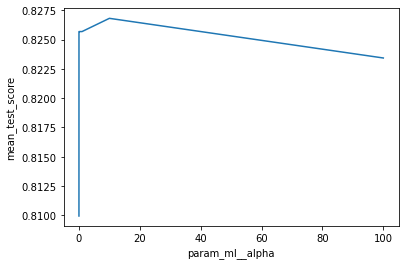

In [83]:
sns.lineplot(x='param_ml__alpha', y='mean_test_score', data=res)

In [49]:
plot_grid_results(plot_grid_results(grid_search, 'clf', 'score');grid_search, 'clf', 'score');

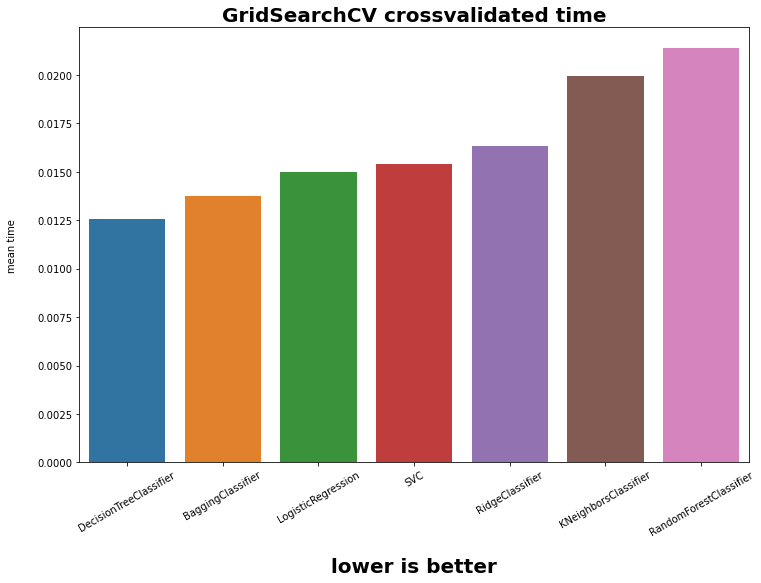

In [126]:
plot_grid_results(grid_search, 'clf', 'time');